# Introduksjon til vitenskaplige beregninger, prosjekt nummer 2.


# Introduksjon

Dette prosjektet omhandler deep-learning, som er en underkategori av maskinlæring. I dette prosjeketet skal maskinen vår løse binære problemstillinger, det vil si at den har to alternativer hvor det ene alternativet er true og det andre er false. Den første problemstillingen går ut på å lære opp programmet til å sortere punkter basert på posisjon for å avgjøre fargen til punktet. Punktene kan enten være blå eller røde. I den andre problemstillingen skal man lære opp programet til å skille mellom to siffer mellom 0 og 9. Måten problemet løses på, er ved å ta inn vektorer som representerer rådataene sammen med en fasit. Man utfører transformasjoner på rådata-vektorene så mange ganger som er gunstig, før man projiserer disse vektorene. Fra denne projiseringen får man en skalar mellom null og en, hvor en representerer positivt utfall og null representerer negativt utfall. Ved hjelp av fasiten kan man dermed forandre på transformasjonene helt til programmets resultat avviker så lite fra fasiten som man selv ønsker. Etter dette lagrer man parametrene som utfører transformasjonene, og programmet er klart til å benyttes.

Denne raporten inneholder først en kort introduksjon av problemstillingene og løsningsmetoden, deretter blir koden og algoritmene brukt i begge oppgavene presentert. Videre presenteres og diskuteres resultatene i de to testproblemene. Til slutt blir valg av parametere begrunnet.

# Biblioteker og globale variabler

In [0]:
#Importerer nyttige biblioteker og hjelpefunksjoner
import numpy as np
import matplotlib.pyplot as plt
from plotting import plot_progression, plot_model, plot_separation
from spirals import get_data_spiral_2d
from loader import get_dataset
import random
import time

#--------------------------------------------------------------------------------------
#Definerer noen konstanter som ikke forandrer seg i løpet av gjennomkjøringene
h = 0.1 #skrittlengde
tau = 0.1 #Læringsparameter

#Konstanter til Adam-descent 
beta1 = 0.9
beta2 = 0.999
alpha = 0.1
epsilon= 10**(-8)
#--------------------------------------------------------------------------------------


# Hjelpefunksjoner

In [0]:
#definerer noen hjelpefunksjoner som benyttes i ulike deler av oppgavene.
def sigma(X): #Sigmoid function
    #Ved andre optimeringsmetoder, er det bare å sette inn nye skaleringsmetoder, avhengig av hva som fungerer

    #return np.tanh(X)       #Brukes i spiralproblemet
    return np.tanh(X/1000)  #Brukes i MNIST problemet.
    

def sigmader(X):#Deriverte av sigma
    return -sigma(X)**2+1
    
def etta(X): #Aktiveringsfunksjon
    return 0.5*(1+sigma(X/2))

def ettader(X): #Deriverte av etta
    return (1/4)*(-(sigma(X/2))**2+1)
#-----------------------------------------------------------------------------------------------------


#Gjør om en batchet B til en med riktig størrelse. (shortB=KxdxI_batch, output=KxdxI_tot)
def finalB(shortB,I_tot): 
    d=len(shortB[0])
    K=len(shortB)
    
    standard= np.zeros((K,d))
    standard=list(standard)
    #Gjør standard til en Kxd med riktige verdier
    for k in range(K):
        for i in range(d):
            standard[k][i]=shortB[k][i][0]
    
    #Gjør standard til KxdxI_max
    for j in range(K):
        standard[j]=list(standard[j])
    for j in range(K):
        standard[j]=[standard[j]]
        for i in range(I_tot-1):
            standard[j].append(standard[j][i])
        standard[j]=np.array(standard[j]).transpose()
    return np.array(standard)
#----------------------------------------------------------------------------------------

def answercheck(Z,C):#Sjekker verdier og fasit og returnerer hvor stor prosentandel er rikitg
    correct=0
    total=0
    for i in range(len(Z)):
        if round(Z[i],0)==C[i]:
            correct+=1
            total+=1
        else:
            total+=1
    return correct*100/total

def formatC(C): #Omdanner fasit C fra True, False til 0,1, og vi kan dermed beregne avvik.
    nyC=[0 for i in range(len(C))]
    for i in range(len(C)):
        if C[i]:
            nyC[i]+=(1)
    return np.array(nyC)

def zconvert(Z): #Runder av Z til 0 eller 1.
    for el in Z:
        el=round(el,0)
    return Z

#--------------------------------------------------------------------------------
def objektfunksjon(Z, C):#Returnerer J, som er en skalar
    J= 0.5 * sum((Z-C)**2) 
    return J

def Jplot(Jliste):      #plotter J med tanke på antall iterasjoner som er utført.
    iterasjoner=[i for i in range(len(Jliste))]
    plt.plot(iterasjoner,Jliste,label="J")
    plt.show()

#------------

# Save/load - parametre

In [0]:
#Disse funksjonene kan benyttes til å lagre samt laste inn parametre
#------------------------------------------------------------------------------------
def makefile(tall=""):#Lager filer for oppbevaring av parametre.
  navnliste=["W-file","b-file","omega-file","my-file"]
  endelse=".npy"
  for el in navnliste:
    f=open(el+str(tall)+endelse,"w")
    f.close()

def saveparam(W,b,omega,my,tall=""):
  navnliste=["W-file","b-file","omega-file","my-file"]
  endelse=".npy"
  paramliste=[W,b,omega,my]
  for i in range(len(navneliste)):
    np.save(navneliste[i]+tall+endelse,paramliste[i])

def loadparam(tall=""):
  navnliste=["W-file","b-file","omega-file","my-file"]
  endelse=".npy"
  paramliste=[W,b,omega,my]
  for i in range(len(paramliste)):
    paramliste[i]=np.load(navneliste[i]+tall+endelse)
  return paramliste[0],paramliste[1],paramliste[2],paramliste[3]


# Inital weights and biases:

In [0]:
#Initialiseringsfunksjon:
def makeOmegaMyWb(K,d,I):       #Initialiserer W,b,omega og my
    omega= np.random.rand(d) /d #definerer omega som d-vektor med tall i [0,1/d]
    my=random.random() /d       #definerer my som tall i [0,1/d]
    W=np.random.rand(K,d,d) /d  #definerer W som Kxdxd med tall i [0,1/d]
    
    #-----------------------------------
    #definerer b som KxdxI med tall i [0,1/d]
    #Grunnen til at vi velger å definere b på dette viset
    #er at vi kjører flere bilder på en gang, ikke ett og ett bilde
    standard= np.random.uniform(0, 1, (K,d) )
    standard=list(standard)
    for j in range(K):
        standard[j]=list(standard[j])
    for j in range(K):
        standard[j]=[standard[j]]
        for i in range(I-1):
            standard[j].append(standard[j][i])
        standard[j]=np.array(standard[j]).transpose()
    b = np.array(standard) /d 
    #---------------------------------------
    return omega, my, W, b

#---------------------------------------------------------------


# Forward propagation

In [0]:

#Anvender vektene og biasene på bildene og transformerer bildevektorene
def bildetransformasjon(Yk, Wk, bk): 
    return Yk + h*sigma(Wk@Yk+bk)
  
#Lager en liste med Y etter transformasjonene (Altså [Y_0, Y_1,..., Y_(K-1)])
def Yfinder(W,b,Y):
    Ylist=[0 for i in range(len(W))]
    Ylist[0]=Y
    for i in range(1,len(W)):
        Y=bildetransformasjon(Y,W[i],b[i])
        Ylist[i]=Y
    return Ylist  
#----------------------------------------------------------------------------------------------------
#Prosjiserer bildematrisen og returnerer Z, som da vil være parametrene våre sin binære klassifisering av bildet (Y_0), oppgitt som en 
#vektor med sannsynligheter mellom 0 og 1
def prosjisering(Y_K,omega,my): 
    return etta( Y_K.transpose()@omega+my*np.ones(len(Y_K[0])) ) 


# Backpropagation

In [0]:
#Funksjoner for back-propagation
#-------------------------------
#Funksjonen finner P_K
def P_K(Y_K, omega, my, Z, C):
    I=len(Y_K[0])

    #En måte å få dx1 @ 1xI =dxI
    faktor1=omega
    faktor1=np.array([faktor1 for i in range(len(faktor1))]).transpose()
    faktor2=( (Z-C) * ettader(Y_K.transpose()@omega + my*np.ones(I)) ).transpose()
    faktor2=np.array([faktor2 for i in range(len(faktor1))])
    return (faktor1@faktor2)/2

#Funksjonen finner P_(k-1) gitt P_k, W_(k-1), Y_(k-1) og b_(k-1)
def P_kmin1(P_k,W_kmin1,Y_kmin1, b_kmin1): 
    return P_k + h*W_kmin1.transpose()@(sigmader(W_kmin1@Y_kmin1 + b_kmin1) * P_k)

#Funksjonen returnerer en liste med alle P-verdiene.
def P_finder(Y,W,b,omega,my,Z,C,zeros): #Returnerer en array [0-matrise, P_1, P_2, ..., P_K]
    K=len(W); I=len(Y[0][0]); d=len(W[0])
    P=zeros                             #zeros er (K+1)xdxI

    P[-1]=P_K(Y[-1],omega,my,Z,C)       #Legger til siste element, P_K
    for k in range(K,1,-1): #Representerer at vi regner P_k. (Går fra K-1 siden K allerede er funnet, og til og med 1, siden P_1 er den laveste vi trenger)
        P[k-1] = P_kmin1(P[k] , W[k-1], Y[k-1], b[k-1]) #Legger til den nye P_k i starten av P-lista

    return P


# Funksjoner for å finne gradienten til J

In [0]:
#------------------------------------------------------------------------------------
#Hjelpefunksjoner som finner komponentene til gradienten av J.
def dJdmy(Yk, omega, my, Z, C, ones):
    return ettader( Yk.transpose()@omega + my*ones ).transpose()@(Z-C)

def dJdomega(Yk,omega, my, Z, C, ones):
    return Yk @ ( (Z - C) * ettader(Yk.transpose()@omega + my*ones ) )

def dJdW(P_kplus1, W_k, Y_k, b_k):
    return h * (P_kplus1 * sigmader(W_k@Y_k + b_k))@Y_k.transpose()

def dJdb(P_kplus1, W_k, Y_k, b_k,ones):
    return h*(P_kplus1 * sigmader(W_k@Y_k + b_k))@ones 
#------------------------------------------------------------------------------------------
#Nablaoperator, regner ut gradienten til J. returnerer gradienten komponentvis
def nabJ(W, b , omega, my,Y,C, dJdWNy, dJdbNy,ones,zeros):
    K=len(W)
    Y_Kmin1 = Y[-1] #Dette er da det siste elementet i Y (som er [Y_0, Y_1,..., Y_(K-1)])

    #Finner Z
    Z = prosjisering(Y_Kmin1, omega, my)
    
    #Finner dJdomega=dx1 og dJdmy=skalar
    dJdomegaNy = dJdomega(Y_Kmin1, omega, my, Z, C, ones[0])
    dJdmyNy = dJdmy(Y_Kmin1, omega, my, Z, C, ones[0])

    #Finner P ([P_0, P_1,..., P_K], hvor P_0 er nullmatrise)
    P = P_finder(Y,W,b,omega,my,Z,C,zeros)
    #Iterer fra [0,K-1] og finner gjennom hver iterasjon dJdW_k og dJdb_k, som til sammen blir hele dJdW=Kxdxd og dJdb=KxdxI
    for i in range(0, K):
        dJdWNy[i]=dJdW(P[i+1], W[i], Y[i], b[i])
        dJdbNy[i]=dJdb(P[i+1],W[i],Y[i],b[i],ones)

    return dJdWNy,dJdbNy,dJdomegaNy,dJdmyNy
#------------------------------------------------------------------------------------------------------


# Optimeringsfunksjoner:



In [0]:
#I begge optimeringsfunksjonene har vi gjort alt komponentvis

#Vanilla-optimering
def optimeringsfunk(W, b , omega, my,Y,C,tau, dJdWNy, dJdbNy,ones, zeros): 
    '''Her vil komponentene av J bevege seg i retningen som minimerer J,
    ergo de vil bevege seg i i retning -nabJ. 
    W2,b2, omega2 og my2 er komponentene til gradienten av J,
    mens W,b,omega og my er komponentene til J'''
    W2,b2,omega2,my2 = nabJ(W, b , omega, my, Y, C, dJdWNy, dJdbNy,ones, zeros) 
    W-= tau*W2;  b-= tau*b2;  omega-= tau*omega2;  my-= tau*my2
    return W,b,omega,my
#---------------------------------------------------------------------------------

#Adam-descent-algortihm
def Adam(W,b, omega, my, Y, C, dJdWNy,dJdbNy, ones,zeros,m0W,m0b,m0omega, m0my, v0W,v0b, v0omega,v0my, i):

    #Finner g_j
    dJdW, dJdb, dJdomega, dJdmy = nabJ(W, b , omega, my,Y,C, dJdWNy, dJdbNy, ones,zeros)
    
    #m_j
    m0W = beta1*m0W + (1-beta1)*dJdW
    m0b = beta1*m0b + (1-beta1)*dJdb
    m0omega = beta1*m0omega + (1-beta1)*dJdomega
    m0my = beta1*m0my + (1-beta1)*dJdmy
    
    #v_j
    v0W = beta2*v0W + (1-beta2)*(dJdW*dJdW)
    v0b = beta2*v0b + (1-beta2)*(dJdb*dJdb)
    v0omega = beta2*v0omega + (1-beta2)*(dJdomega*dJdomega)
    v0my = beta2*v0my + (1-beta2)*(dJdmy*dJdmy)
    
    #mhatt_j
    mhattW = m0W / ( 1 - beta1**(i+1) ) #i+1 siden vi starter indekser på 0, mens denne skal starte på 1
    mhattb = m0b / ( 1 - beta1**(i+1) )
    mhattomega = m0omega / ( 1 - beta1**(i+1) )
    mhattmy = m0my / ( 1 - beta1**(i+1) )
    
    #vhatt_j
    vhattW = v0W / ( 1 - beta2**(i+1) )
    vhattb = v0b / ( 1 - beta2**(i+1) )
    vhattomega = v0omega / ( 1 - beta2**(i+1) )
    vhattmy = v0my / ( 1 - beta2**(i+1) )
    
    #U_(j+1)
    W -= alpha * mhattW / ( np.sqrt(vhattW) + epsilon )
    b -= alpha * mhattb / ( np.sqrt(vhattb) + epsilon )
    omega -= alpha * mhattomega / ( np.sqrt(vhattomega) + epsilon )
    my -= alpha * mhattmy / ( np.sqrt(vhattmy) + epsilon )
  
    return W, b, omega, my, m0W, m0b, m0omega, m0my, v0W, v0b, v0omega, v0my
    

# Treningsalgoritmer

In [0]:
#Initialiserer og trener W,b,omega,my på et treningssett maxiter ganger, eller når toleransen er nådd. adamopt er bool
def generalTrain(pictures,fasit,K,Jtol,adamopt):
    I=len(pictures[0]); d=len(pictures)  #Henter ut lengde og format.

    omega,my,W,b = makeOmegaMyWb(K,d,I)  #omega=dx1, my=skalar, W=Kxdxd, b=KxdxI,    tall innhold i [0,1/d]

    #Definerer noen matriser for bruk i senere funksjoner slik at vi kun inistialiserer dem én gang
    Kdd0 = np.zeros((K, d,d))     #Kxdxd med 0 i hvert element
    KdI0 = np.zeros((K, d, I))    #KxdxI med 0 i hvert element
    II1=np.ones((I,I))            #IxI med 1 i hvert element
    zeros=np.zeros((K+1,d,I))     #Brukes i P-finder
    #---

    #Øvre iterasjonsgrense
    #maxiter=1000                  #Brukes i spiral-problemet
    maxiter=10                   #Brukes i MNIST-problemet

    iter=0                        #Starter på ingen iterasjoner
    J=[100]                       #Lager liste med J, altså avvikene
    #---

    #Lager en matrise lik W men med 0 i alle elementer tilsvarende for b,omega og my
    m0W=0*np.copy(W); m0b=0*np.copy(b); m0omega=0*np.copy(omega); m0my=0*np.copy(my)
    v0W=np.copy(m0W); v0b=np.copy(m0b); v0omega=np.copy(m0omega); v0my=np.copy(m0my)

    #
    while(J[-1]>Jtol and iter<maxiter):     #Begynner å iterere

        Y=Yfinder(W,b,pictures)             #Anvender W og b på bildet
        Z=prosjisering(Y[-1],omega,my)      #Får ut liste med sannsynligheter

        #-------
        #Regner ut og oppdaterer W,b,omega,my etter gradienten
        if adamopt:#Bruker adamopt
          W,b,omega,my, m0W, m0b, m0omega, m0my, v0W, v0b, v0omega, v0my = Adam(W,b, omega, my, Y, fasit, Kdd0,KdI0, II1,zeros, m0W,m0b,m0omega, m0my, v0W,v0b, v0omega,v0my, iter)
        else:#Bruker vanilla
          W,b,omega,my=optimeringsfunk(W,b,omega,my,Y,fasit,tau, Kdd0, KdI0,II1,zeros)
        #--------

        #For å plotte J som en funksjon av iterasjoner
        J.append(objektfunksjon(Z,fasit))
    del J[0] #Fjerner den verdien vi initialiserte med

    return W,b,omega,my,answercheck(Z,fasit),J #returnerer opptrente parametre samt siste accuracy-måling
#---------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------
#Trener W,b,omega,my på et treningssett maxiter ganger, eller når toleransen er nådd
#denne funksjonen benyttes når vi kjører batches, da vi skal ta inn W,b, omega og my fra tidligere kjøringer
def trainAgain(W,b,omega,my,Y0,fasit,K,Jtol,adamopt):
    I=len(Y0[0]); d=len(Y0)#Henter ut format

    #Definerer noen matriser for bruk i senere funksjoner
    Kdd0 = np.zeros((K, d,d)) #Kxdxd med 0 i hvert element
    KdI0 = np.zeros((K, d, I)) #KxdxI med 0 i hvert element
    II1=np.ones((I,I)) #IxI med 1 i hvert element
    zeros=np.zeros((K+1,d,I))#Brukes i P-finder
    #---

    #Øvre iterasjonsgrense
    #maxiter=1000                  #Brukes i spiral-problemet
    maxiter=10                   #Brukes i MNIST-problemet

    iter=0
    J=[1000]
    #---
    #Lager en matrise lik W men med 0 i alle elementer tilsvarende for b,omega og my
    m0W=0*np.copy(W); m0b=0*np.copy(b); m0omega=0*np.copy(omega); m0my=0*np.copy(my)
    v0W=np.copy(m0W); v0b=np.copy(m0b); v0omega=np.copy(m0omega); v0my=np.copy(m0my)

    while(J[-1]>Jtol and iter<maxiter):#Begynner å iterere

        Y=Yfinder(W,b,Y0) #Applyer W og b til bildet
        Z=prosjisering(Y[-1],omega,my) #Får ut liste med sannsynligheter
    
        #---------
        #Regner ut og oppdaterer W,b,omega,my etter gradienten
        if adamopt:#Adam
          W,b,omega,my, m0W, m0b, m0omega, m0my, v0W, v0b, v0omega, v0my = Adam(W,b, omega, my, Y, fasit, Kdd0,KdI0, II1,zeros, m0W,m0b,m0omega, m0my, v0W,v0b, v0omega,v0my, iter)
        else:#Vanilla
          W,b,omega,my=optimeringsfunk(W,b,omega,my,Y,fasit,tau, Kdd0, KdI0,II1,zeros)
        #--------

        #For å plotte J som en funksjon av iterasjoner
        J.append(objektfunksjon(Z,fasit))
        iter+=1
    del J[0]#Fjerner første element som vi hadde satt som 1000

    return W,b,omega,my,answercheck(Z,fasit),J

In [0]:
#Funksjon som deler opp bildene i pakker og kjører pakkevis

def batchTrain(pictures,fasit,K,Jtol,batchsize,adamopt):
    #-------
    #Lager currentbatch og currentfasit
    batches=len(pictures[0])//batchsize
    picinvert=pictures.transpose() #inverterer bilde-matrisen
    currentbatch=picinvert[0:batchsize].transpose() #Lager et mindre bilde med lengde batchsize
    currentfasit=fasit[0:batchsize]
    #------
    #Bruker generalTrain første gangen for å initialisere W,b,omega,my
    W,b,omega,my,currentacc,J = generalTrain(currentbatch,currentfasit,K,Jtol,adamopt)#Initsialiserer W,b,omega og my og trener dem på batch nr 1
    #---
    #Trener samme W,b,omega og my på nye bildebatcher
    for i in range(1,batches-1):
        #Henter ny currentbatch og currentfasit
        currentbatch=picinvert[batchsize*i:batchsize*(i+1)].transpose()
        currentfasit=fasit[batchsize*i:batchsize*(i+1)]
        #Trener W,b,omega,my
        W,b,omega,my,currentacc,Jny=trainAgain(W,b,omega,my,currentbatch,currentfasit,K,Jtol,adamopt)
        J+=Jny #Legger til J-tilegget fra batch-treningen
        #Dersom vi har et lite nok avvik, så breaker den ut av forløkka og returnerer W,b,omega,my
        if J[-1]<Jtol:
          break

    return W,b,omega,my,J #MERK!! Tar ikke med restbilder om bilder%batches >0(dvs rest)

# Oppgave 4.1 - Spiraler


In [0]:
#To forskjellige treningsfunksjoner. En som kjører alle bildene samtidig, og en som deler opp i batcher
def trainingspiral(I,K,tol,adamopt):
  Y0,C=get_data_spiral_2d(I)
  C=formatC(C)
  return generalTrain(Y0,C,K,tol)

def batchspiral(I,K,tol,batchsize,adamopt):
  Y0,C=get_data_spiral_2d(I)
  C=formatC(C)
  return batchTrain(Y0,C,K,tol,batchsize,adamopt)


Accuracy og avvik fra siste batchen: 99.8 0.9995783559487913


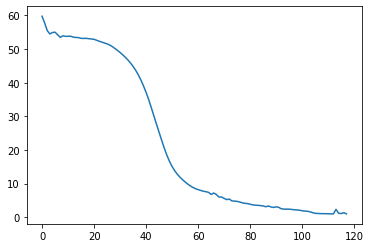

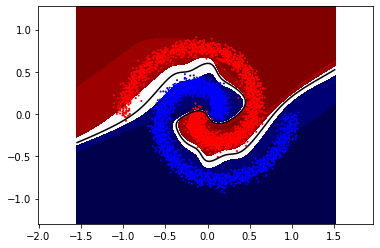

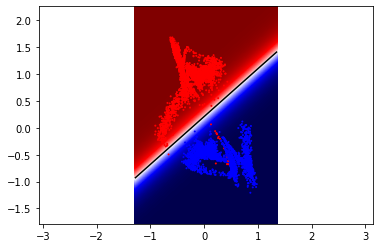

Prosent riktige: 99.62 %
kjøretid:  8.166829586029053


In [0]:
#Dette er algoritmen vår som man kan kjøre og teste
def testSpirals(I,K,tol,batchsize,batch,adamopt):#I er antall bilder, K er antall lag, batchsize er bilder per batch,batch er bool, adamopt er bool
    startTid = time.time()#Tar tiden ved start
    if batch:
      W,b,omega,my,J=batchspiral(I,K,tol,batchsize,adamopt) #Initialiserer og optimaliserer W,b,omega,my batchvis.
      b=finalB(b,I) #Gir b riktig format for å fungere på alle bilder samtidig
    else:
      W,b,omega,my,J = trainingspiral(I,K,tol)
    Jplot(J) #Plotter J med iterasjonsnummer på x-aksen. Unaturlige hopp kan skyldes ny batch
    
    spiralpoints, fasit = get_data_spiral_2d(I) #Lager et nytt datasett vi skal teste nettverket vårt på
    fasit=formatC(fasit) #Gjør fasiten(C) leselig
    spirallist=Yfinder(W,b,spiralpoints) #Anvender W og b på Y
    spirallist=np.array(spirallist)
    Z=prosjisering(spirallist[-1],omega,my) #Finner Z, som vil være Ix1 med tall i intervallet [0,1]

    EnDimPixler=500
    def forward_function(Y0):
        Y = Yfinder(W,finalB(b,int(EnDimPixler**2)),Y0)
        Z=prosjisering(Y[-1],omega,my)
        Z=zconvert(Z)
        return Z
    def last_function(Y_Kmin1):
        Z=prosjisering(Y_Kmin1,omega,my)
        Z=zconvert(Z)
        return Z

    #plot_progression(spirallist,fasit)#Brukt under testing
    plot_model(forward_function,spirallist[0],fasit,EnDimPixler)
    plot_separation(last_function,spirallist[-1],fasit,EnDimPixler)
    print("Prosent riktige:",answercheck(Z,fasit),"%")

    sluttTid = time.time()#Tar tiden ved slutt
    print("kjøretid: ", sluttTid-startTid)


testSpirals(5000,17,1,500,True,True)#10 000 bilder, 17 lag, 1 toleranse, 500 bilder per batch, ja til batching, ja til adamopt




Vi ser fra grafen hvor kvadratisk avvik, J, blir plottet mot iterasjoner, at etter 60 iterasjoner begynner programmet å lære hvordan den skal sortere punktene effektivt. Dette fortsettes en liten stund helt til vi har mindre avvik enn hva minstekravet er, som vi antar betyr at koden er god nok.

Fra plottene med spiralene ser vi at punktene starter i en spiral, men avhengig av posisjonen til punktene, beveger de seg i en eller annen retning. Dette tyder på at programmet bruker posisjonen til punktene til å avgjøre om de er rød eller blå. Derfor vil noen av punktene som befinner seg veldig tett opptil motsatt farget punkter bevege seg i feil retning. For en god del av punktene som beveger seg i feil retning vil programmet etter hvert identifisere denne feilen, men dette forblir en feilkilde i programmet. Måten man kan minske denne feilkilden mest mulig, er ved å ha mange nok iterasjoner av mange nok bilder eller batcher.

En annen feilkilde, som minimeres når man kjører treningen i batches, er at det å bevege seg langs negativ gradient ikke er ensbetydende med å bevege seg mot globalt minimum. Man kan derfor ende i en situasjon hvor komponentene til $J$ beveger seg mot et lokalt minimum. Dette resulterer i en høyere $J$ enn hva som er gunstig, og dermed et dårligere resultat. Hvis man kjører batches, istedefor å kjøre alle bildene på en gang, vil man unngå dette problemet til større grad, da det er vanskeligere å ende opp i lokale minimum flere ganger. En annen måte å unngå dette problemet på er ved å forandre på læringsparameteren $\tau$ og steglengden $h$.

# Oppgave 4.2 - MNIST

In [0]:
#Deler opp mnist bildene i batcher og trener på batchene. K antall lag, batchsize er bilder per batch, adamopt er bool
def mnistbatchtrain(K,Jtol,batchsize,adamopt):
    Y0,fasit=get_dataset("training",4,9)#Lager et datasett med 1-ere og 7-ere
    fasit=formatC(fasit)#Fikser formatet på fasiten
    W,b,omega,my,J = batchTrain(Y0,fasit,K,Jtol,batchsize,adamopt)#trener opp W,b,omega og my
    b=finalB(b,len(Y0[0]))#Utvider b slik at den passer orginalformatet
    return W,b,omega,my, J

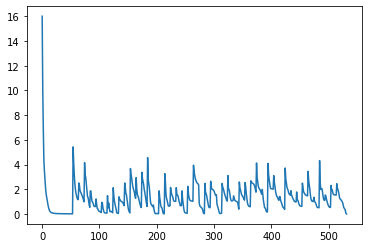

Endelig test: 96.63485685585133
Mnist kjøretid: 73.73102188110352


In [22]:
#Dette er algoritmen vår som tester mnist. 
def mnisttest(K,Jtol,adamopt):
  time1=time.time()#Tar tiden fra start til slutt
  W,b,omega,my, J = mnistbatchtrain(K,Jtol,128,adamopt)
  Jplot(J)
  Y0,fasit2=get_dataset("testing",4,9)

  fasit2=formatC(fasit2)
  b=finalB(b,len(Y0[0]))
  Ylist=Yfinder(W,b,Y0)
  Z=prosjisering(Ylist[-1],omega,my)
  print("Endelig test:",answercheck(Z,fasit2))
  time2=time.time()
  print("Mnist kjøretid:",time2-time1)


mnisttest(2,0.01,True)



I gjennomkjøringen har vi testet med 4 og 9, men man kan velge siffer selv. Et resultat på 96.6% treffsikkerhet på testdataen med disse sifrene er meget bra, da de er meget like.

Fra plottet ser man at kvadratisk avvik $J$ synker meget fort og konvergerer til en verdi etter noen iterasjoner. I denne problemstillingen kjører vi batcher for å forbedre kjøretiden. Dette resulterer i små fluktuasjoner når man går fra en batch til en annen. Programmet opptimaliseres for en batch, og når programmet starter på en ny en, er ikke programmet nødvendigvis helt riktig trent opp. Det er først etter flere batches at programmet kan sies å være godt trent.

# Valg av konstanter og parametre

**Valg av parametere:**  

For å velge hva de ulike konstantene og parametrene skulle bli ble prøve-og-feile metoden tatt i bruk, helt til det ble funnet konstanter og parametre som ga bra resultater.

$K$:  
For valg av antall lag $K$, testet vi fra $K=2$ til $K=40$ i begge problemene. I spiralproblemet oppdaget vi at rundt 20 lag var tilstrekkelig, og vi gikk for 17 lag da dette ga bra resultater samt at kjøretiden var lav. I MNIST-problemet fant vi ut at vi ikke trengte mange lag, og at vi fikk bra resultater med $K=2$.

$h$:  
Vi testet for $h \in [0.01, 1]$. Fra dette fant vi at $h=0.1$ ga best resultater. 

$\tau$:  
Vi prøvde med ulike verdier for læringsparameteren $\tau \in [0.01,0.1]$, og observerte at ved $\tau=0.1$ flukserte objektfunksjonen $J$ mye mer enn ved $\tau=0.01$, men at den også klarte å få mye lavere verdier for $J$. Vi tror dette skyldes at $J$ har stor sannsynlighet for å sitte fast i et lokalt minima ved lav verdi av $\tau$. Siden en høy verdi for $\tau$ gjør at $J$ hopper mer, klarer den i større grad å hoppe ut av lokale minima og havne nært globale minima. Vi valgte derfor $\tau=0.1$
  
$\alpha$:  
$\alpha$ har samme oppgave som $\tau$, bare at der $\tau$ brukes i vanilla optimering, brukes $\alpha$ i Adam Descent. Ved testing av ulike verdier for $\alpha$, observerte vi at det samme gjaldt for $\alpha$ som gjaldt for $\tau$, og vi valgte derfor $\alpha=0.1$